In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [4]:
DBPATH = "bigrams_index"
SOURCES = ['dev', 'train', 'test']
#SOURCES = ['dev']
SEARCH_RESULT_PATH = "data/search_results_v3.csv"

In [5]:
!xapian-delve $DBPATH

UUID = f8fab680-224e-426c-9efe-cd5abea8d234
number of documents = 5378626
average document length = 205.718
document length lower bound = 1
document length upper bound = 69924
highest document id ever used = 5378626
has positional information = true
revision = 538
currently open for writing = false


In [6]:
!xapian-delve -r 40001 -d $DBPATH

Data for record #40001:
{"page_id": "1992_Los_Angeles_Rams_season", "shard": "001", "text": [{"sent_id": 0, "text": "The 1992 Los Angeles Rams season was the team 's 55th year with the National Football League and the 47th season in Los Angeles ."}, {"sent_id": 1, "text": "In a scheduling quirk , the Rams ' first four opponents were all AFC East teams ."}, {"sent_id": 2, "text": "The Rams ' final twelve games were against only NFC teams ."}, {"sent_id": 5, "text": "According to Football Outsiders , the 1992 Rams had the second-worst run-defense they had ever tracked ."}, {"sent_id": 6, "text": "The Rams allowed 383 points , the second most in the league in 1992 ."}, {"sent_id": 7, "text": "The Rams were also second-worst in the league in total allowed yards -LRB- 5,523 -RRB- , allowed rushing yards -LRB- 2,230 -RRB- , and yards per rushing attempt -LRB- 4.8 -RRB- ."}]}
Term List for record #40001: '_final '_first 's_55th -lrb-_2,230 -lrb-_4.8 -lrb-_5,523 -rrb-_yards 1992 1992_los 1992_

In [7]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

stop_tags = ['DT', 'VB', 'VBP', 'VBD', 'VBN', 'VBZ',  'MD', 'IN', 'TO', 'PRP', 'CC',
             "(", ')', '.', ',', 'PRP$', 'VBG', 'RB', "''", "``", 'WDT', ':', 'WRB']

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vitaly/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Retrieve documents relevant to claims

In [8]:
def get_doc_id(match):
    for term in match.document.termlist():
        term = term.term.decode("utf-8") 
        m = re.match("Q(.*)", term)
        if m:
            return m[1]
    return None

In [9]:
# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(DBPATH)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
queryparser.set_stemmer(xapian.Stem("en"))
queryparser.set_stemming_strategy(queryparser.STEM_SOME)
#queryparser.add_prefix('keywords', 'K')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)    

In [10]:
query = 'first time in three seasons the team failed'
pagesize = 10
claim_id = 1

query = queryparser.parse_query(query)
print(query)
enquire.set_query(query)
matches = enquire.get_mset(0, pagesize)

query_results = []
for match in matches:
    result = dict(
        claim_id = claim_id,
        found_doc = get_doc_id(match),
        rank = match.rank + 1,
        percentage = match.percent,
        weight = match.weight,            
    )
    query_results.append(result)
query_results

Query((Zfirst@1 OR Ztime@2 OR Zin@3 OR Zthree@4 OR Zseason@5 OR Zthe@6 OR Zteam@7 OR Zfail@8))


[{'claim_id': 1,
  'found_doc': '1976_St._Louis_Cardinals_-LRB-NFL-RRB-_season',
  'percentage': 100,
  'rank': 1,
  'weight': 23.602006139435574},
 {'claim_id': 1,
  'found_doc': '1955_Detroit_Lions_season',
  'percentage': 95,
  'rank': 2,
  'weight': 22.454961718873975},
 {'claim_id': 1,
  'found_doc': '1948_New_York_Yankees_-LRB-AAFC-RRB-_season',
  'percentage': 94,
  'rank': 3,
  'weight': 22.291511829994043},
 {'claim_id': 1,
  'found_doc': '2004–05_Milwaukee_Bucks_season',
  'percentage': 93,
  'rank': 4,
  'weight': 22.168553324749855},
 {'claim_id': 1,
  'found_doc': '1992_Los_Angeles_Raiders_season',
  'percentage': 92,
  'rank': 5,
  'weight': 21.918549856867884},
 {'claim_id': 1,
  'found_doc': '2005–06_Houston_Rockets_season',
  'percentage': 91,
  'rank': 6,
  'weight': 21.65729549105503},
 {'claim_id': 1,
  'found_doc': '2015_Stanley_Cup_playoffs',
  'percentage': 91,
  'rank': 7,
  'weight': 21.529774252788478},
 {'claim_id': 1,
  'found_doc': '1950_Philadelphia_Eagles

In [11]:
claim_df = pd.read_json('data/claims_lm.json').sort_index()

In [12]:
mask = claim_df.source.isin(SOURCES)
claim_df = claim_df[mask]

In [13]:
claim_df.head()

,claim,source,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots
3,Chris Hemsworth appeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Getaway', 'label': 'WORK_OF_ART', 'root': 'Getaway'}]","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', 'root': 'Getaway'}]",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]"
4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Getaway', 'label': 'WORK_OF_ART', 'root': 'Getaway'}]","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', 'root': 'Getaway'}]",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]"
6,Firefox is an application.,test,"[{'entity': 'Firefox', 'label': 'ORG', 'root': 'Firefox'}]","[{'noun_phrase': 'Firefox', 'root': 'Firefox'}, {'noun_phrase': 'an application', 'root': 'application'}]",1,[ORG],1,2,"[Firefox, an application]","[Firefox, application]"
7,Roald Dahl is a writer.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a writer', 'root': 'writer'}]",1,[PERSON],1,2,"[a writer, Roald Dahl]","[Dahl, writer]"
8,Roald Dahl is a governor.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a governor', 'root': 'governor'}]",1,[PERSON],1,2,"[a governor, Roald Dahl]","[Dahl, governor]"


In [14]:

# tokenise and remove stop words
def parse_df(df, text_column):
    raw_df = df[[text_column]].copy()
    raw_df['tokens'] = raw_df[text_column].apply(word_tokenize)
    raw_df['tokens'] = raw_df.tokens.apply(lambda tokens: [w for w in tokens if not w in stop_words])

    # determine parts of speech and remove stop tags
    raw_df['tagged'] = raw_df.tokens.apply(nltk.pos_tag)
    raw_df['tagged'] = raw_df.tagged.apply(lambda pairs: [(w, t) for w, t in pairs if not t in stop_tags])

    # extract keywords
    raw_df['keywords'] = raw_df.tagged.apply(lambda pairs: [w for w, t in pairs if not t in stop_tags])
    
    func = lambda ngrams: ["_".join(ngram).lower() for ngram in ngrams]
    raw_df['ngrams'] = raw_df.keywords.apply(lambda x: func(nltk.bigrams(x)))
    return raw_df


In [15]:
search_df = parse_df(claim_df, 'claim')

In [16]:
claim_df = claim_df.join(search_df.ngrams)

In [17]:
claim_df.head()

,claim,source,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots,ngrams
3,Chris Hemsworth appeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Getaway', 'label': 'WORK_OF_ART', 'root': 'Getaway'}]","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', 'root': 'Getaway'}]",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]","[chris_hemsworth, hemsworth_perfect, perfect_getaway]"
4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Getaway', 'label': 'WORK_OF_ART', 'root': 'Getaway'}]","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', 'root': 'Getaway'}]",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]","[chris_hemsworth, hemsworth_perfect, perfect_getaway]"
6,Firefox is an application.,test,"[{'entity': 'Firefox', 'label': 'ORG', 'root': 'Firefox'}]","[{'noun_phrase': 'Firefox', 'root': 'Firefox'}, {'noun_phrase': 'an application', 'root': 'application'}]",1,[ORG],1,2,"[Firefox, an application]","[Firefox, application]",[firefox_application]
7,Roald Dahl is a writer.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a writer', 'root': 'writer'}]",1,[PERSON],1,2,"[a writer, Roald Dahl]","[Dahl, writer]","[roald_dahl, dahl_writer]"
8,Roald Dahl is a governor.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a governor', 'root': 'governor'}]",1,[PERSON],1,2,"[a governor, Roald Dahl]","[Dahl, governor]","[roald_dahl, dahl_governor]"


In [18]:
claim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165447 entries, 3 to 229449
Data columns (total 11 columns):
claim                 165447 non-null object
source                165447 non-null object
named_entities        165447 non-null object
noun_phrases          165447 non-null object
entity_count          165447 non-null int64
entity_types          165447 non-null object
entity_types_count    165447 non-null int64
np_count              165447 non-null int64
np_phrase             165447 non-null object
np_roots              165447 non-null object
ngrams                165447 non-null object
dtypes: int64(3), object(8)
memory usage: 20.1+ MB


In [19]:
claim_df.shape

(165447, 11)

In [20]:
search_column = 'ngrams'

In [21]:
%%time
fields = ['claim_id', 'found_doc', 'rank', 'percentage', 'weight']
pagesize = 100
i = 0
results = []

with open(SEARCH_RESULT_PATH, 'w') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()

    for claim_id, claim, keywords in claim_df[['claim', search_column]].itertuples():
        if i % 1000 == 0:
            print(i // 1000, claim_id)
        i += 1

        
        #claim = 'keywords:"{}" {}'.format(" ".join(keywords), claim)
        #if isinstance(claim, list):
        #    claim = ' '.join(claim)
        #print(claim)
        query_str = "{} {}".format(claim, " ".join(keywords))
        query = queryparser.parse_query(query_str)
        #print(query)
        enquire.set_query(query)
        matches = enquire.get_mset(0, pagesize)

        query_results = []
        for match in matches:
            result = dict(
                claim_id = claim_id,
                found_doc = get_doc_id(match),
                rank = match.rank + 1,
                percentage = match.percent,
                weight = match.weight,            
            )
            query_results.append(result)
        writer.writerows(query_results)
        results += query_results
csvFile.close()

0 3
1 131
2 266
3 389
4 540
5 684
6 836
7 957
8 1102
9 1258
10 1395
11 1531
12 1670
13 1806
14 1934
15 2073
16 2205
17 2340
18 2492
19 2622
20 2767
21 2900
22 3027
23 3180
24 3319
25 3441
26 3590
27 3717
28 3853
29 3990
30 4127
31 4267
32 4406
33 4541
34 4678
35 4815
36 4952
37 5076
38 5218
39 5340
40 5469
41 5604
42 5741
43 5863
44 6018
45 6153
46 6282
47 6404
48 6532
49 6655
50 6788
51 6908
52 7036
53 7166
54 7299
55 7419
56 7565
57 7684
58 7813
59 7943
60 8072
61 8210
62 8346
63 8479
64 8616
65 8759
66 8899
67 9028
68 9148
69 9297
70 9430
71 9577
72 9718
73 9851
74 9978
75 10116
76 10270
77 10400
78 10534
79 10667
80 10793
81 10935
82 11080
83 11220
84 11348
85 11505
86 11635
87 11766
88 11901
89 12039
90 12165
91 12301
92 12440
93 12576
94 12707
95 12837
96 12967
97 13102
98 13238
99 13380
100 13521
101 13652
102 13775
103 13917
104 14049
105 14185
106 14325
107 14464
108 14603
109 14733
110 14864
111 14991
112 15125
113 15268
114 15390
115 15526
116 15664
117 15796
118 15927
119 1

830 113236
831 113371
832 113516
833 113664
834 113803
835 113941
836 114103
837 114235
838 114381
839 114508
840 114640
841 114783
842 114927
843 115068
844 115210
845 115358
846 115511
847 115641
848 115780
849 115922
850 116056
851 116220
852 116380
853 116525
854 116674
855 116804
856 116928
857 117063
858 117219
859 117357
860 117481
861 117632
862 117783
863 117916
864 118054
865 118194
866 118333
867 118472
868 118611
869 118740
870 118876
871 119013
872 119146
873 119283
874 119424
875 119559
876 119689
877 119846
878 119989
879 120121
880 120283
881 120429
882 120574
883 120711
884 120846
885 120990
886 121127
887 121276
888 121417
889 121561
890 121696
891 121838
892 121980
893 122124
894 122266
895 122407
896 122551
897 122688
898 122826
899 122967
900 123114
901 123249
902 123384
903 123528
904 123683
905 123826
906 123964
907 124107
908 124243
909 124371
910 124499
911 124629
912 124756
913 124885
914 125020
915 125160
916 125289
917 125437
918 125578
919 125719
920 125853

1527 211816
1528 211960
1529 212122
1530 212260
1531 212407
1532 212514
1533 212639
1534 212792
1535 212921
1536 213058
1537 213187
1538 213290
1539 213399
1540 213548
1541 213690
1542 213862
1543 213976
1544 214082
1545 214208
1546 214328
1547 214436
1548 214544
1549 214742
1550 214906
1551 215037
1552 215184
1553 215359
1554 215494
1555 215681
1556 215800
1557 215944
1558 216055
1559 216188
1560 216317
1561 216478
1562 216622
1563 216754
1564 216871
1565 217033
1566 217186
1567 217334
1568 217461
1569 217638
1570 217755
1571 217938
1572 218060
1573 218188
1574 218311
1575 218420
1576 218536
1577 218641
1578 218759
1579 218869
1580 218978
1581 219124
1582 219268
1583 219449
1584 219559
1585 219672
1586 219891
1587 220031
1588 220201
1589 220367
1590 220546
1591 220712
1592 220852
1593 220974
1594 221103
1595 221322
1596 221435
1597 221567
1598 221709
1599 221812
1600 221914
1601 222030
1602 222171
1603 222336
1604 222452
1605 222576
1606 222738
1607 222881
1608 223002
1609 223122
1610

# Analyse Found Documents

## Read search results

In [22]:
import unicodedata

In [24]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)

normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
results_df['found_doc'] = results_df['found_doc'].apply(normalise)

In [25]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16544003 entries, 0 to 16544002
Data columns (total 5 columns):
claim_id      int64
found_doc     object
rank          int64
percentage    int64
weight        float64
dtypes: float64(1), int64(3), object(1)
memory usage: 631.1+ MB


In [26]:
#results_df.sort_values('percentage', ascending=False).head(100)
results_df.sort_values('weight', ascending=False).head(10)

,claim_id,found_doc,rank,percentage,weight
12995503,179663,Michael_Giacchino,1,59,240.52
12992703,179617,Michael_Giacchino,1,59,240.52
12992503,179614,Michael_Giacchino,1,59,240.52
12993403,179627,Michael_Giacchino,1,59,240.52
14299703,199112,International_relations,1,55,235.53
14296603,199065,International_relations,1,55,235.53
14293803,199030,International_relations,1,55,235.53
14296303,199061,International_relations,1,55,235.53
14294903,199043,International_relations,1,55,235.53
14291503,198993,International_relations,1,55,235.53


## Read claims

In [27]:
sources = SOURCES
if 'test' in sources:
    sources.remove('test')
    
labelled_claims_df = pd.read_json('data/l_claims.json').sort_index()
mask = labelled_claims_df.source.isin(sources)
labelled_claims_df = labelled_claims_df[mask]

In [28]:
labelled_claims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[Chris_Hemsworth, 2]]",SUPPORTS,train,[Chris_Hemsworth],1,1,{'Chris_Hemsworth'}
4,Chris Hemsworth disappeared in A Perfect Getaway.,[],NOT ENOUGH INFO,train,[],0,0,set()
7,Roald Dahl is a writer.,"[[Roald_Dahl, 0]]",SUPPORTS,train,[Roald_Dahl],1,1,{'Roald_Dahl'}
8,Roald Dahl is a governor.,"[[Roald_Dahl, 0]]",REFUTES,train,[Roald_Dahl],1,1,{'Roald_Dahl'}
9,Ireland has relatively low-lying mountains.,"[[Ireland, 10]]",SUPPORTS,train,[Ireland],1,1,{'Ireland'}


## Estimate index-search performance

In [51]:
def calculate_recall(mask):
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)
    return recall_df

In [52]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['rank'] <= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['top'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 4min 36s, sys: 20.8 s, total: 4min 57s
Wall time: 4min 58s


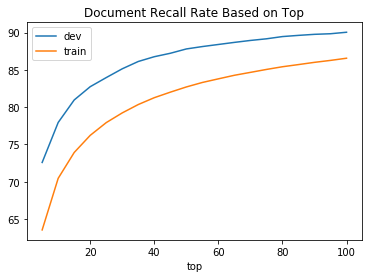

,dev,train
top,,
5.0,72.59,63.54
10.0,77.94,70.46
15.0,80.96,73.92
20.0,82.74,76.22
25.0,83.96,77.93
30.0,85.14,79.23
35.0,86.12,80.35
40.0,86.76,81.27
45.0,87.22,82.01


In [53]:
df = pd.DataFrame.from_records(results).set_index('top')
df.plot.line(title='Document Recall Rate Based on Top')
plt.show()
df

In [54]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['percentage'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['percentage'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 3min 29s, sys: 13.3 s, total: 3min 42s
Wall time: 3min 43s


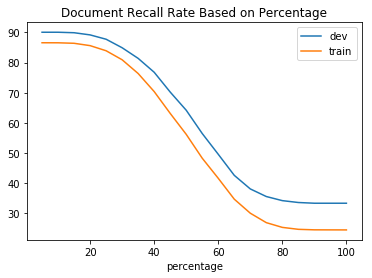

,dev,train
percentage,,
5.0,90.04,86.56
10.0,90.04,86.55
15.0,89.88,86.38
20.0,89.16,85.60
25.0,87.72,83.91
30.0,84.90,80.92
35.0,81.38,76.37
40.0,76.78,70.39
45.0,70.23,63.16


In [55]:
df = pd.DataFrame.from_records(results).set_index('percentage')
df.plot.line(title='Document Recall Rate Based on Percentage')
plt.show()
df

In [56]:
%%time

results = []
for top in range(10, 25, 2):
    #print(top)
    mask = results_df['weight'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['weight'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 2min 11s, sys: 13.7 s, total: 2min 24s
Wall time: 2min 27s


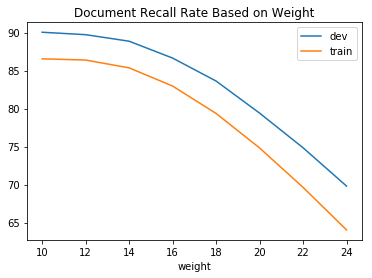

,dev,train
weight,,
10.0,90.04,86.55
12.0,89.72,86.38
14.0,88.86,85.36
16.0,86.64,82.96
18.0,83.62,79.36
20.0,79.40,74.82
22.0,74.85,69.64
24.0,69.81,64.04


In [57]:
df = pd.DataFrame.from_records(results).set_index('weight')
df.plot.line(title='Document Recall Rate Based on Weight')
plt.show()
df

## Search performance with filters applied

In [75]:
mask = (results_df['rank'] <= 20)# & (results_df.weight > 10) #& (results_df.percentage > 25)
recall_df = calculate_recall(mask)
recall_df = (recall_df / recall_df.sum() * 100)#.head(1)
recall_df.head(1)

source,dev,train
missed_count,,
0,82.74,76.22


In [76]:
results_df.found_doc.unique().shape[0], results_df[mask].found_doc.unique().shape[0] 

(2103728, 679635)

## Prepare submission

In [59]:
mask = (results_df['rank'] <= 10) & (results_df.percentage > 25) & (results_df.weight > 15)
submission_df = results_df[mask].set_index('claim_id')[['found_doc']].join(claim_df.claim)
submission_df.head()

,found_doc,claim
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Hemsworth_-LRB-surname-RRB-,Chris Hemsworth appeared in A Perfect Getaway.
3,Kim_Hyde,Chris Hemsworth appeared in A Perfect Getaway.
3,Liam_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Vanessa_Zachos,Chris Hemsworth appeared in A Perfect Getaway.


In [60]:
results_df.shape, submission_df.shape,

((16544003, 5), (1512098, 2))

In [61]:
results_df.head()

,claim_id,found_doc,rank,percentage,weight
0,3,Chris_Hemsworth,1,70,35.08
1,3,Hemsworth_-LRB-surname-RRB-,2,53,26.80
2,3,Kim_Hyde,3,44,22.10
3,3,Liam_Hemsworth,4,42,21.27
4,3,Vanessa_Zachos,5,41,20.97


In [62]:
results_df.found_doc.unique().shape, submission_df.found_doc.unique().shape

((2103728,), (344990,))

In [63]:
submission_df['label'] = "SUPPORTS"
submission_df['evidence'] = submission_df.found_doc.apply(lambda x: [[x, 0]])

In [64]:
del submission_df['found_doc']

In [65]:
submission_df.head()

,claim,label,evidence
3,Chris Hemsworth appeared in A Perfect Getaway.,SUPPORTS,"[[Chris_Hemsworth, 0]]"
3,Chris Hemsworth appeared in A Perfect Getaway.,SUPPORTS,"[[Hemsworth_-LRB-surname-RRB-, 0]]"
3,Chris Hemsworth appeared in A Perfect Getaway.,SUPPORTS,"[[Kim_Hyde, 0]]"
3,Chris Hemsworth appeared in A Perfect Getaway.,SUPPORTS,"[[Liam_Hemsworth, 0]]"
3,Chris Hemsworth appeared in A Perfect Getaway.,SUPPORTS,"[[Vanessa_Zachos, 0]]"


In [66]:
#submission_df.to_json('testoutput.json', orient='index')

In [67]:
submission_df.shape

(1512098, 3)

## Evidence found

In [68]:
found_docs_df = results_df.pivot_table(index='claim_id', values='found_doc', aggfunc=list)
recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

def func(x):
    if isinstance(x['found_doc'], list):
        return set(x['evidence_docs']).difference(set(x['found_doc']))
    return set(x['evidence_docs'])

recall_df['missed_docs'] = recall_df.apply(func, axis=1)
recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

In [69]:
recall_df[recall_df.missed_count > 0]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count
8,[Roald_Dahl],train,Roald Dahl is a governor.,"[The_Collected_Short_Stories_of_Roald_Dahl, Roald_Dahl_Children's_Gallery, Roald_Dahl's_Book_of_Ghost_Stories, The_Roald_Dahl_Omnibus, Twenty-Nine_Kisses_from_Roald_Dahl, Memories_with_Food_at_Gip...",{Roald_Dahl},1
31,[Greece],train,Greece is a country.,"[Albanian_immigrants_in_Greece, Tourism_in_Greece, Croatia–Greece_relations, Athanassios_Tsakiris, Bangladesh–Greece_relations, Finland–Greece_relations, Name_of_Greece, Australia–Greece_relations...",{Greece},1
32,[Greece],train,Greece is a European country.,"[Croatia–Greece_relations, Greece_national_cricket_team, International_Hellenic_University, Treaty_of_Accession_1979, European_Parliament_election,_2014_-LRB-Greece-RRB-, Economy_of_Greece, Greece...",{Greece},1
35,[Australia],train,Australia is a member of 8 intergovernmental organizations.,"[International_university, International_parliament, Inter-parliamentary_institution, Intergovernmental_organization, International_Organization_for_Migration, International_Commission_on_Civil_St...",{Australia},1
36,[Australia],train,Australia is not a member of 8 intergovernmental organizations.,"[Inter-parliamentary_institution, International_parliament, Intergovernmental_organization, International_university, World_Nature_Organization, International_Organization_for_Migration, Member_st...",{Australia},1
50,"[Xhosa_people, Nelson_Mandela]",train,Nelson Mandela is a person.,"[Nelson_Mandela_School, Mandela_Day, Lycée_Nelson_Mandela, Nelson_Mandela_-LRB-disambiguation-RRB-, Statue_of_Nelson_Mandela,_Johannesburg, Nelson_Mandela_-LRB-EP-RRB-, Nelson_Mandela_Bay_Metropo...",{Xhosa_people},1
52,[Colombia],train,Colombia is in North America.,"[Postage_stamps_and_postal_history_of_Colombia, Prestoea, Colombia–Panama_border, Geography_of_Venezuela, List_of_sovereign_states_and_dependent_territories_in_North_America, Google_Street_View_in...",{Colombia},1
61,[World_War_II],train,World War II took place from 1939 to 1945.,"[List_of_Soviet_Union_military_equipment_of_World_War_II, Occupation_of_Poland_-LRB-disambiguation-RRB-, The_Second_World_War_-LRB-disambiguation-RRB-, Croix_de_guerre_1939–1945_-LRB-France-RRB-, ...",{World_War_II},1
62,[World_War_II],train,World War II took place on Earth.,"[Battle_of_Lunga_Point, Fourth_Battle_of_Savo_Island, Alexandra_Braun, Battle_of_the_Bloody_Ridge, Strategic_Command_-LRB-video_game_series-RRB-, Battle_of_Mairy, Ismail_Boçari, Russian_Campaign_...",{World_War_II},1
107,[Doctor_Who],train,Doctor Who is in the science-fiction genre.,"[British_television_science_fiction, J.M._Frey, Gerry_Davis_-LRB-screenwriter-RRB-, Chris_Boucher, Voord, Science_Fiction_South_Africa, Sanctuary_-LRB-Doctor_Who_novel-RRB-, Doctor_Who_Online, Lib...",{Doctor_Who},1


In [70]:
found_df = labelled_claims_df[(labelled_claims_df.missed_count == 0) & (labelled_claims_df.label != 'NOT ENOUGH INFO')]

AttributeError: 'DataFrame' object has no attribute 'missed_count'

In [ ]:
found_df.evidence_docs.astype(str).value_counts().to_frame()

## Evidence missed

In [ ]:
missed_df = labelled_claims_df[labelled_claims_df.missed_count > 0]

In [ ]:
missed_df = missed_df.join(claim_df[['named_entities', 'np_phrase']])

In [ ]:
cols = ['claim', 'named_entities', 'np_phrase', 'evidence_docs',
       'evidence_doc_count', 'found_doc', 'missed_docs', 'missed_count']
missed_df.sort_values(['missed_count', 'evidence_set_str'], ascending=[False, True])[cols].head(100)

In [ ]:
missed_df.missed_docs.astype(str).value_counts().to_frame()